In [1]:
# Test migration history reconstruction on simulated data

import sys
import os

repo_dir = "/Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/met_history_prediction/"
os.chdir(repo_dir)
from src.lib import vertex_labeling

from src.util import machina_data_extraction_util as mach_util
from src.util import vertex_labeling_util as vert_util
import matplotlib
import torch

MACHINA_DATA_DIR = os.path.join(repo_dir, 'src/data/machina_sims')


In [2]:
custom_colors = [matplotlib.colors.to_hex(c) for c in ['limegreen', 'cornflowerblue', 'hotpink', 'grey', 'saddlebrown', 'darkorange', 'purple', 'red', 'black', 'black', 'black', 'black']]

def find_labelings_all_mutation_trees(cluster_fn, all_mut_trees_fn, ref_var_fn):
    cluster_label_to_idx = mach_util.get_cluster_label_to_idx(cluster_fn, ignore_polytomies=True)
    print(cluster_label_to_idx)
    
    data = mach_util.get_adj_matrices_from_all_mutation_trees(all_mut_trees_fn, cluster_label_to_idx, is_sim_data=True)
    print("num trees:", len(data))
    for adj_matrix, pruned_cluster_label_to_idx in data:
        T = torch.tensor(adj_matrix, dtype = torch.float32)
        B = vert_util.get_mutation_matrix_tensor(T)
        ref_matrix, var_matrix, unique_sites= mach_util.get_ref_var_matrices_from_machina_sim_data(ref_var_fn, 
                                                                                                   pruned_cluster_label_to_idx=pruned_cluster_label_to_idx,
                                                                                                   T=T)
        idx_to_label = {v:k for k,v in pruned_cluster_label_to_idx.items()}
        print(unique_sites)   
        primary_idx = unique_sites.index('P')
        r = torch.nn.functional.one_hot(torch.tensor([primary_idx]), num_classes=len(unique_sites)).T

        vertex_labeling.gumbel_softmax_optimization(T, ref_matrix, var_matrix, B, ordered_sites=unique_sites, 
                                                    p=r, node_idx_to_label=idx_to_label, 
                                                    w_e=5, w_l=2, w_m=10, w_c=5, max_iter=150, batch_size=64,
                                                    #w_e=0.01, w_l=10, w_m=50, w_c=25, max_iter=150, batch_size=64, 
                                                    custom_colors=custom_colors, show_top_trees=False)

import pydot
from IPython.display import Image, display

def visualize_ground_truth(tree_fn, graph_fn):
    def view_pydot(pdot):
        plt = Image(pdot.create_png())
        display(plt)
    
    (graph,) = pydot.graph_from_dot_file(tree_fn)
    view_pydot(graph)

    (graph,) = pydot.graph_from_dot_file(graph_fn)
    view_pydot(graph)
        
        

Ground truth


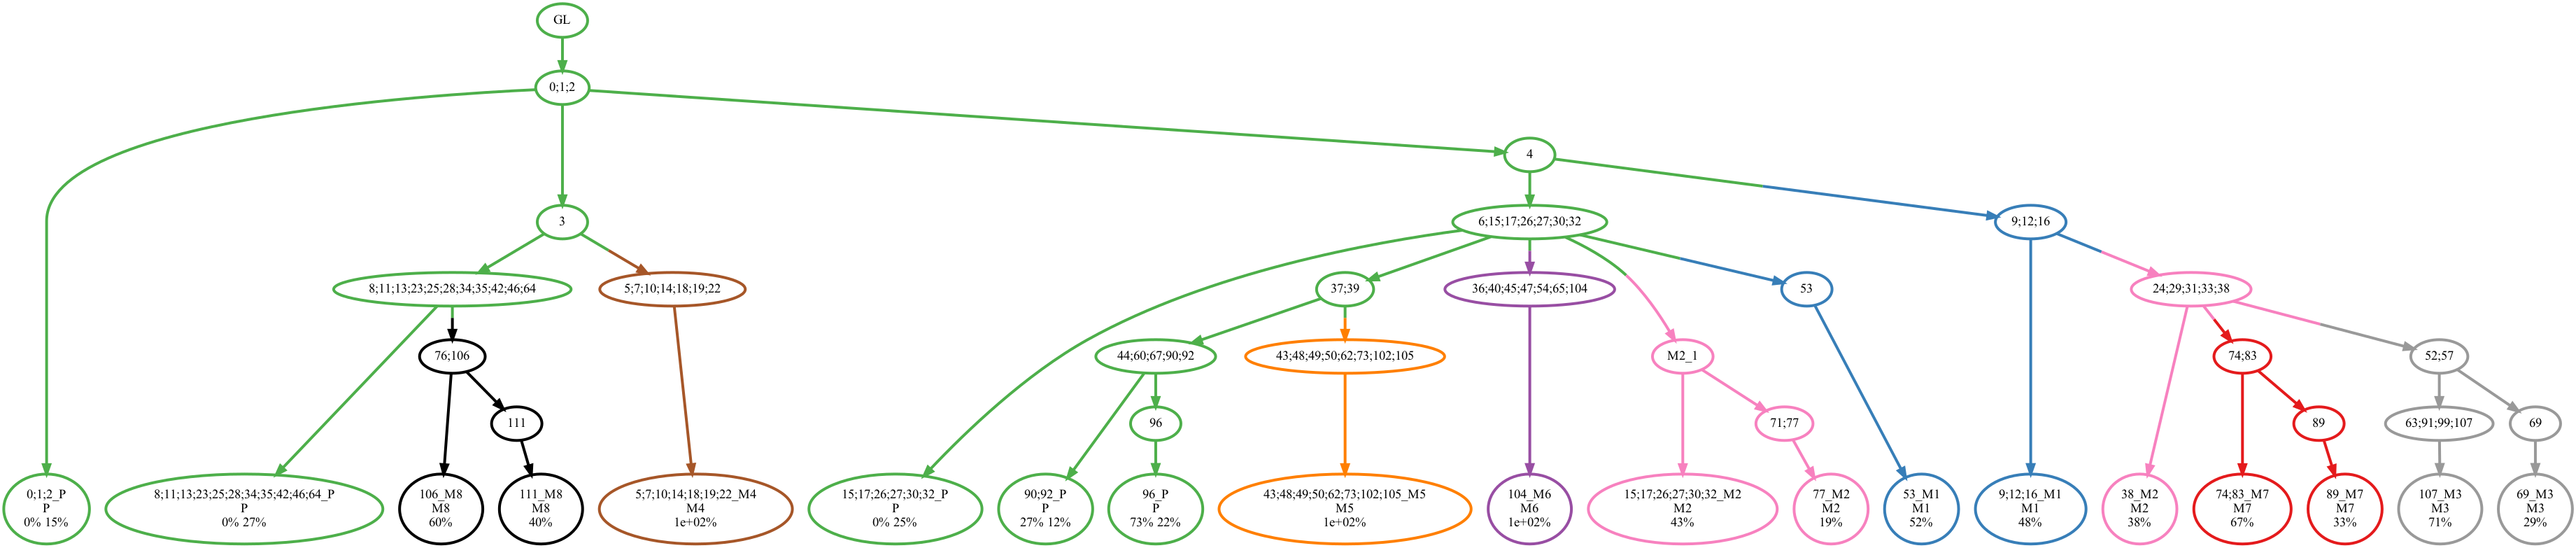

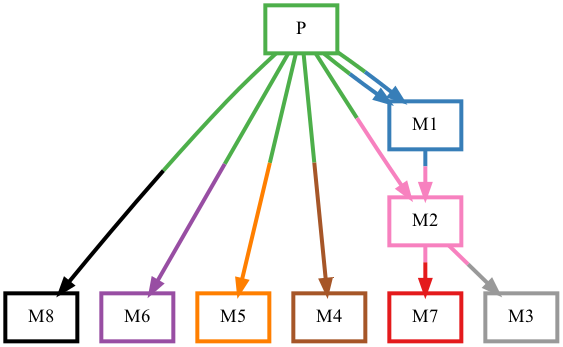

In [5]:
num_sites = "m8"
mig_type = "M"
SEED = 76
SIM_DATA_DIR = os.path.join(MACHINA_DATA_DIR, num_sites, mig_type)

print("Ground truth")
visualize_ground_truth(os.path.join(SIM_DATA_DIR, f"T_seed{SEED}.dot"), os.path.join(SIM_DATA_DIR, f"G_seed{SEED}.dot"))


OrderedDict([('0;1;2', 0), ('3', 1), ('4', 2), ('9;12;16', 3), ('5;7;10;14;18;19;22', 4), ('6;15;17;26;27;30;32', 5), ('24;29;31;33;38', 6), ('37;39', 7), ('53', 8), ('8;11;13;23;25;28;34;35;42;46;64', 9), ('71;77', 10), ('74;83', 11), ('89', 12), ('44;60;67;90;92;96', 13), ('36;40;45;47;54;65;104', 14), ('43;48;49;50;62;73;102;105', 15), ('76;106', 16), ('52;57;63;69;91;99;107', 17), ('111', 18)])
num trees: 4
['P', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8']


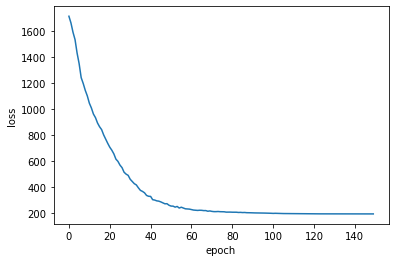

Migration number: 11.0
Comigration number: 10.0
Seeding site number: 3.0
Neg log likelihood: 1.272
L1: 8.999999046325684
Loss: 187.359


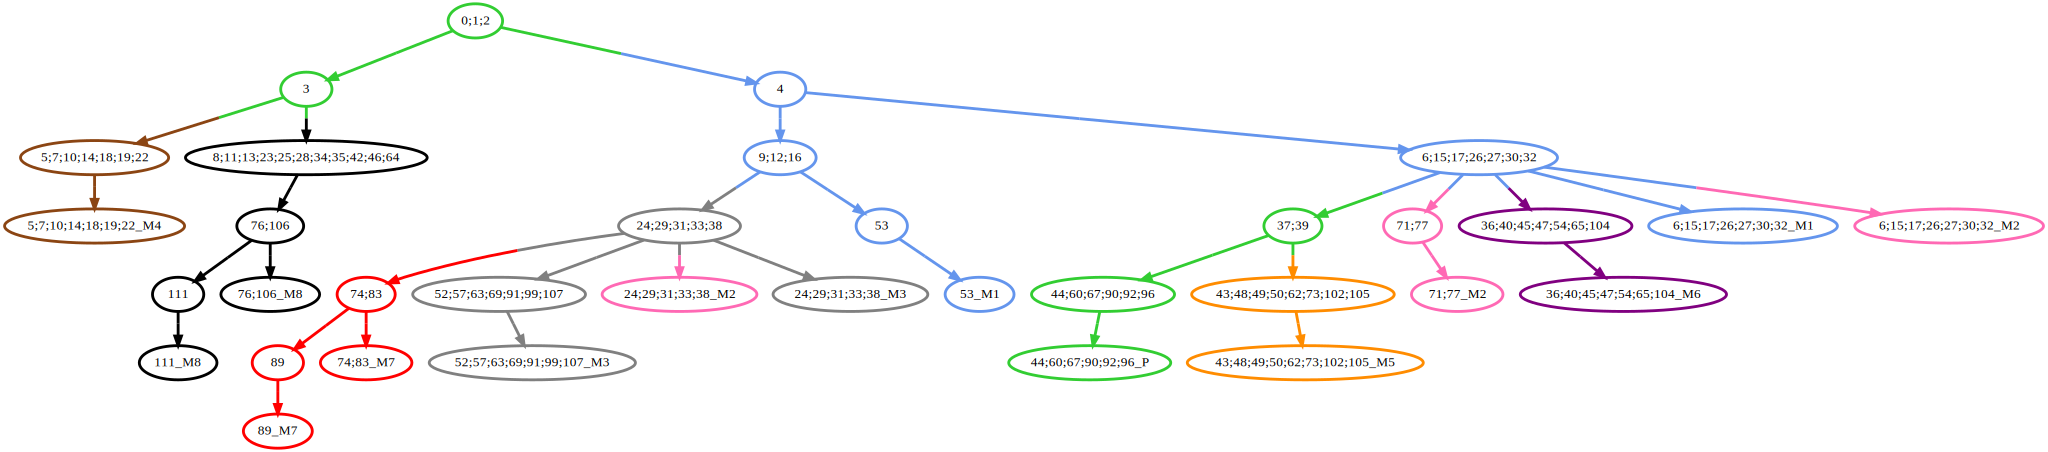

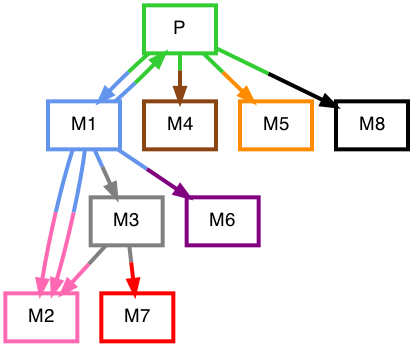

['P', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8']


In [ ]:
%%time

find_labelings_all_mutation_trees(os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{SEED}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_mut_trees", f"mut_trees_{mig_type}_seed{SEED}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{SEED}.tsv"))


